In [ ]:
# cnn_training.py  –– create & save the Rough-Heston surface-to-θ CNN
# ================================================================
import math, pathlib, time, warnings
import numpy as np
import tensorflow as tf
from tensorflow import keras as K
import torch, torch.nn.functional as F

warnings.filterwarnings("ignore")
torch.set_default_dtype(torch.double)

# ---------------------------------------------------------------
# 0.  global knobs
# ---------------------------------------------------------------
OUT_DIR   = pathlib.Path.cwd().parent / "SensitiveData"
OUT_DIR.mkdir(exist_ok=True)
MODEL_OUT = OUT_DIR / "rough_heston_cnn.h5"

# synthetic data set size
N_TRAIN   = 60_000          # ~3 GB in RAM (reduce if needed)
BATCH_MC  = 8_000           # MC paths per training surface

# rough-Heston constants
H, N_FAC, T_MAX = 0.1, 10, 1.0
R_RATE, DT      = 0.05, 1/252
MAT_GRID        = np.array([15,30,60,90,120,180,270,360])/365
MNY_EDGES       = np.linspace(-0.25, 0.25, 31)        # 30 bins ⇒ 8×30 grid

# seeds for reproducibility
np.random.seed(21)
torch.manual_seed(21)

# ---------------------------------------------------------------
# 1.  helper – rough-Heston MC price surface (torch, CPU/GPU)
# ---------------------------------------------------------------
lam = np.exp(np.linspace(math.log(1/T_MAX), math.log(1e4/T_MAX), N_FAC))
wgt = np.array([math.gamma(H+0.5)/l**(H+0.5) for l in lam]); wgt /= wgt.sum()
LAM = torch.tensor(lam);  WGT = torch.tensor(wgt)
SQRT2PI = math.sqrt(2*math.pi)

@torch.no_grad()
def mc_surface(theta_raw, S0=1.0, n_paths=8_000, n_steps=60):
    """
    Returns an 8×30 call-price surface (normalised by S0),
    *plus* the option meta-info (K,T×8×30) so that
    implied-vol calculation is easy later.
    """
    # unpack raw → (ξ,rho,v0)
    xi  = F.softplus(theta_raw[0])
    rho = torch.tanh(theta_raw[1])
    v0  = F.softplus(theta_raw[2])

    # strike grid (8×30) in absolute prices
    Krel = np.exp(np.linspace(MNY_EDGES[0], MNY_EDGES[-1], 30))
    Kmat = np.repeat(Krel[None,:], MAT_GRID.size, axis=0)
    K    = torch.tensor(Kmat * S0)

    # pre-allocate tensors
    disc = torch.exp(-R_RATE*torch.tensor(MAT_GRID))
    S = torch.full((n_paths,), S0)
    f = torch.zeros(n_paths, N_FAC)
    f[:,0] = torch.sqrt(v0)/(xi*WGT[0])

    # antithetic Brownian increments
    zS  = torch.randn(n_paths//2, n_steps);  zS = torch.cat([zS,-zS])
    zV0 = rho*zS + torch.sqrt(1-rho*rho)*torch.randn_like(zS)
    zV  = torch.cat([zV0.unsqueeze(2),
                     torch.randn(n_paths, n_steps, N_FAC-1)], 2)

    sqrt_dt = math.sqrt(DT);  decay = torch.exp(-LAM*DT)
    for t in range(n_steps):
        f = f*decay + sqrt_dt*zV[:,t]
        v = torch.clamp((xi*(f@WGT))**2, 1e-10)
        S = S*torch.exp((-0.5*v)*DT + torch.sqrt(v)*sqrt_dt*zS[:,t])

    # payoff (vectorised for all 8×30 strikes)
    payoff = torch.relu(S[:,None] - K.flatten())
    P_flat = disc.repeat_interleave(30)*payoff.mean(0)
    P = P_flat.reshape(8,30) / S0           # scale by spot

    return P.numpy().astype('float32')      # 8×30 surface


# ---------------------------------------------------------------
# 2.  generate full training set (θ_raw ↔ surface)
# ---------------------------------------------------------------
def draw_theta_raw(n):
    """
    Draw *raw* CNN targets θ_raw ~ Uniform(−2,2)^3
    (covering a broad range of ξ,ρ,v0 after transforms).
    """
    u = np.random.uniform(-2,2,size=(n,3)).astype('float32')
    return u

def build_dataset(n_samples, n_paths=BATCH_MC):
    X = np.empty((n_samples,8,30,1),dtype='float32')
    y = np.empty((n_samples,3),     dtype='float32')

    for i in tqdm(range(n_samples),desc="synth surfaces"):
        θr = draw_theta_raw(1)[0]
        surf = mc_surface(torch.tensor(θr), n_paths=n_paths)
        X[i,...,0] = surf
        y[i]       = θr
    return X, y


# ---------------------------------------------------------------
# 3.  conv-net architecture
# ---------------------------------------------------------------
def build_cnn():
    model = K.Sequential([
        K.layers.Input((8,30,1)),
        K.layers.Conv2D(32,(3,3),activation='relu',padding='same'),
        K.layers.MaxPool2D((2,2)),
        K.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
        K.layers.Flatten(),
        K.layers.Dense(128,activation='relu'),
        K.layers.Dense(3)                 # raw θ  (no activation)
    ])
    model.compile(optimizer=K.optimizers.Adam(1e-3), loss='mse')
    return model


# ---------------------------------------------------------------
# 4.  train & save
# ---------------------------------------------------------------
def main():
    print(f"Device for MC (torch): {torch.get_default_dtype()}  |  CNN (TF): {tf.config.experimental.list_physical_devices('GPU')}")
    t0 = time.time()
    X,y = build_dataset(N_TRAIN, n_paths=BATCH_MC)
    print(f"\nSynthetic data built in {(time.time()-t0):.1f}s\n")

    cnn = build_cnn()
    cnn.fit(X, y, batch_size=256, epochs=20,
            validation_split=0.05,
            callbacks=[K.callbacks.EarlyStopping(patience=3, restore_best_weights=True)])
    cnn.save(MODEL_OUT)
    print(f"\n✓ model saved to {MODEL_OUT}")

if __name__ == "__main__":
    main()


✓ Parquet already present – skipping WRDS pull

Surface 2023-08-31  |  Spot 4516.08

✓ CNN loaded
CNN raw θ: [-7.0482683 -1.0284947 -3.0432596]

◂ Adam phase (price+IV blend) ▸


Adam:   0%|          | 0/200 [00:00<?, ?it/s]

  · early-stop at 142

◂ IV-space LBFGS ▸

Refined θ: [-2.23182889 -3.2057243  -5.34066994]


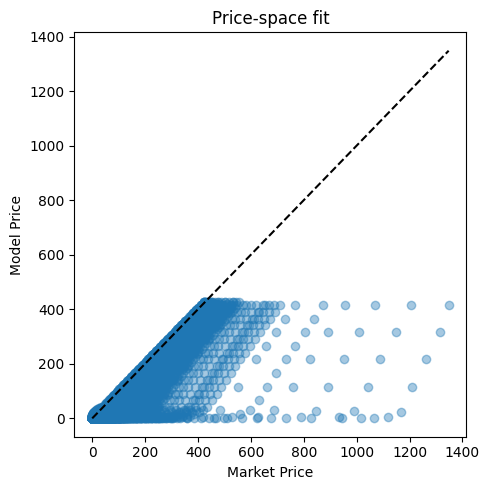

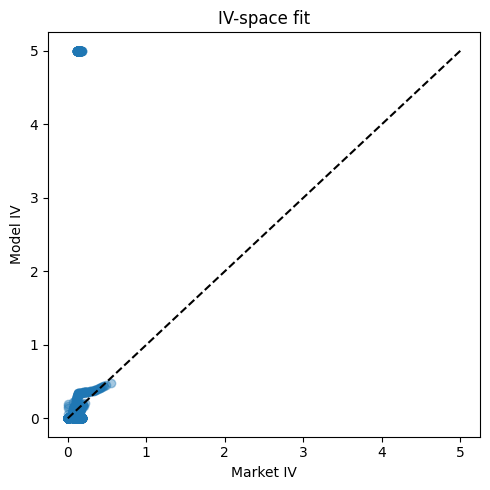

Vega-weighted RMSE (price): 2.9919e+03


In [1]:
# calibration_and_diagnostics.py

# =============================================================
# 0.  imports & global knobs
# =============================================================
import os, math, warnings, pathlib, time
from datetime import datetime

import numpy as np, pandas as pd
import pyarrow.parquet as pq, pyarrow as pa
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import wrds, torch, torch.nn.functional as F
from tensorflow import keras as K
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")
torch.set_default_dtype(torch.double)

DEVICE  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VERBOSE = True

# ─── calibration knobs ────────────────────────────────────────
MC_PATHS_FAST    = 25_000        # smoother Adam gradients
MC_STEPS_FAST    =   60
MC_PATHS_FINE    = 60_000        # hi-res for IV-LBFGS
MC_STEPS_FINE    =  120
CLAMP_RAW        = 10.0          # allow ξ, v0 up into double‐digits
ADAM_LR          = 5e-2          # stronger initial Adam steps
BLEND_IV_WEIGHT  = 0.50          # 50/50 blend of price‐ and IV‐loss in Adam
EARLY_PATIENCE   = 12            # looser early‐stop
MNY_LIMIT        = 0.10
# =============================================================


# =============================================================
# 1.  WRDS pull  (cached parquet)
# =============================================================
YEARS, SPX_SECID = range(2021,2024), 108105
OUT   = pathlib.Path.cwd().parent / "SensitiveData"; OUT.mkdir(exist_ok=True)
PARQ  = OUT / "spx_option_data_2021-2023.parquet"
CNNF  = OUT / "rough_heston_cnn.h5"

def fetch_spx():
    if PARQ.exists():
        if VERBOSE: print("✓ Parquet already present – skipping WRDS pull")
        return
    db = wrds.Connection()
    rf = (web.DataReader('DGS3MO','fred',
                         datetime(min(YEARS),1,1),
                         datetime(max(YEARS),12,31))
          .rename(columns={'DGS3MO':'rf'}).reset_index())
    rf['rf']  /= 100
    rf['date'] = pd.to_datetime(rf['DATE'])
    rf = rf[['date','rf']]

    writer = None
    for yr in YEARS:
        print(f"▸ pulling {yr}")
        opt = db.raw_sql(f"""
          SELECT date,secid,strike_price,best_bid,best_offer,
                 exdate,cp_flag
          FROM optionm.opprcd{yr}
          WHERE secid='{SPX_SECID}'
        """)
        if opt.empty: continue
        opt['strike_price'] /= 1000
        opt['date']   = pd.to_datetime(opt['date'])
        opt['exdate'] = pd.to_datetime(opt['exdate'])
        opt['mid_price'] = (opt.best_bid + opt.best_offer)/2
        opt = opt.merge(rf, on='date', how='left').ffill()

        und = db.raw_sql(f"""
          SELECT secid,date,low,high,close,open
          FROM optionm.secprd{yr}
          WHERE secid='{SPX_SECID}'
        """)
        if und.empty: continue
        und['date'] = pd.to_datetime(und['date'])
        und['S']    = und[['low','high','close','open']].mean(axis=1)
        und = und[['secid','date','S']]

        df = opt.merge(und, on=['secid','date']).dropna(subset=['S'])
        if df.empty: continue
        tbl = pa.Table.from_pandas(df, preserve_index=False)
        if writer is None:
            writer = pa.ParquetWriter(PARQ, tbl.schema)
        writer.write_table(tbl)

    if writer: writer.close()
    db.close()


# =============================================================
# 2.  Build latest 8×30 surface
# =============================================================
MAT = np.array([15,30,60,90,120,180,270,360]) / 365
MNY = np.linspace(-0.25, 0.25, 31)

def latest_surface():
    df = pq.read_table(PARQ).to_pandas()
    if 'S' not in df.columns:
        df = df.rename(columns={'underlying_price':'S'})

    spx = df[(df.secid==SPX_SECID)&(df.cp_flag=='C')&(df.mid_price>0)]
    ref = spx.date.max()
    spx = spx[spx.date==ref]
    S0  = float(spx.S.iloc[0])

    spx['mny'] = np.log(spx.strike_price/S0)
    spx['T']   = (spx.exdate-ref).dt.days/365
    spx        = spx[spx['T'].between(0.04,1)]

    grid = np.full((8,30), np.nan)
    for i,T in enumerate(MAT):
        blk  = spx[np.isclose(spx['T'],T,atol=1/365)]
        bins = np.digitize(blk.mny, MNY) - 1
        for p,b in zip(blk.mid_price, bins):
            if 0<=b<30: grid[i,b] = p

    grid = (pd.DataFrame(grid)
              .ffill(axis=1).bfill(axis=1)
              .ffill().bfill()
              .fillna(grid.mean())
              .values.astype('float32'))
    return grid, S0, ref


# =============================================================
# 3.  Load CNN
# =============================================================
def load_cnn():
    if VERBOSE: print("✓ CNN loaded")
    return K.models.load_model(CNNF)


# =============================================================
# 4.  Rough‐Heston MC + BS‐IV helpers
# =============================================================
H,N_FAC,T_MAX = 0.1,10,1.0
R_RATE,DT     = 0.05,1/252
lam = np.exp(np.linspace(math.log(1/T_MAX),
                         math.log(1e4/T_MAX), N_FAC))
wgt = np.array([math.gamma(H+0.5)/l**(H+0.5) for l in lam])
wgt /= wgt.sum()
LAM, WGT = (torch.tensor(lam,device=DEVICE),
            torch.tensor(wgt,device=DEVICE))

def mc_price(raw, K, T, S0, n_paths, n_steps):
    raw = raw.to(DEVICE)
    xi, rho, v0 = (F.softplus(raw[0]),
                   torch.tanh(raw[1]),
                   F.softplus(raw[2]))
    Kt, Tt = map(lambda x: torch.as_tensor(x,device=DEVICE),(K,T))
    disc   = torch.exp(-R_RATE*Tt)

    half = n_paths//2
    zS   = torch.randn(half,n_steps,device=DEVICE)
    zS   = torch.cat([zS,-zS],0)  # antithetic
    zV0  = rho*zS + torch.sqrt(1-rho*rho)*torch.randn_like(zS)
    zV   = torch.cat([zV0.unsqueeze(2),
                      torch.randn(n_paths,n_steps,N_FAC-1,
                                   device=DEVICE)],2)

    S = torch.full((n_paths,),S0,device=DEVICE)
    f = torch.zeros(n_paths,N_FAC,device=DEVICE)
    f[:,0] = torch.sqrt(v0)/(xi*WGT[0])

    sqrt_dt, decay = math.sqrt(DT), torch.exp(-LAM*DT)
    for t in range(n_steps):
        f = f*decay + sqrt_dt*zV[:,t]
        v = torch.clamp((xi*(f@WGT))**2,1e-10)
        S = S*torch.exp((-0.5*v)*DT + torch.sqrt(v)*sqrt_dt*zS[:,t])

    payoff    = torch.relu(S.unsqueeze(1)-Kt)
    P         = disc*payoff.mean(0)
    intrinsic = torch.clamp(S0-Kt,min=0.0)
    maxv      = intrinsic.new_full(intrinsic.shape,0.999*S0)
    return torch.clamp(P,intrinsic+1e-6,maxv)


SQRT2PI = math.sqrt(2*math.pi)
def iv_from_price(price, S, K, T, guess=0.2):
    price,S,K,T = [x.to(DEVICE) for x in (price,S,K,T)]
    σ = torch.full_like(price, guess, device=DEVICE)
    for _ in range(10):
        d1    = (torch.log(S/K)+0.5*σ**2*T)/(σ*torch.sqrt(T)+1e-12)
        d2    = d1 - σ*torch.sqrt(T)
        c     = (S*0.5*(1+torch.erf(d1/math.sqrt(2)))
                 -K*torch.exp(-R_RATE*T)*0.5*(1+torch.erf(d2/math.sqrt(2))))
        vega  = S*torch.exp(-0.5*d1**2)/SQRT2PI * torch.sqrt(T)
        σ     = torch.clamp(σ-(c-price)/vega.clamp_min(1e-8),
                             1e-4,5.0)
    return torch.nan_to_num(σ,nan=5.0)

bs_iv    = iv_from_price
bs_vega  = lambda S,K,T,σ: (
    S*torch.exp(-0.5*((torch.log(S/K)+0.5*σ**2*T)/(σ*torch.sqrt(T)+1e-12))**2)
    / SQRT2PI * torch.sqrt(T)
)


# =============================================================
# 5.  Two‐stage calibration
# =============================================================
def huber(res, δ=0.05):
    return torch.where(res.abs()<δ, 0.5*res**2/δ, res.abs()-0.5*δ)

def calibrate(theta0, K, T, mid, S0):
    K,T,mid = map(lambda x: np.asarray(x,dtype=np.float64),(K,T,mid))
    θ = torch.tensor(np.clip(theta0,-CLAMP_RAW,CLAMP_RAW),
                     dtype=torch.double,requires_grad=True,device=DEVICE)

    Kt, Tt, mid_t = [torch.tensor(x,dtype=torch.double,device=DEVICE)
                     for x in (K,T,mid)]

    # precompute market IV + vega
    iv_t   = bs_iv(mid_t, torch.tensor(S0,device=DEVICE), Kt, Tt)
    vega_t = bs_vega(torch.tensor(S0,device=DEVICE), Kt, Tt, iv_t).clamp_min(1e-3)
    W_price = 1/vega_t
    W_iv    = 1/vega_t

    # --- Adam (blended price+IV) ---
    optA  = torch.optim.Adam([θ], lr=ADAM_LR)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(optA, T_max=150)
    best, bad = 1e9, 0

    if VERBOSE: print("\n◂ Adam phase (price+IV blend) ▸")
    for it in tqdm(range(200), disable=not VERBOSE, desc="Adam"):
        optA.zero_grad()
        P     = mc_price(θ,K,T,S0,MC_PATHS_FAST,MC_STEPS_FAST)
        σ     = bs_iv(P, torch.tensor(S0,device=DEVICE), Kt, Tt)
        lp    = torch.mean(W_price * huber(P-mid_t))
        li    = torch.mean(W_iv    * (σ-iv_t)**2)
        loss  = (1-BLEND_IV_WEIGHT)*lp + BLEND_IV_WEIGHT*li
        loss.backward(); optA.step(); sched.step()
        θ.data.clamp_(-CLAMP_RAW, CLAMP_RAW)

        l = loss.item()
        if l < best-1e-4:
            best, bad = l, 0
        else:
            bad += 1
        if bad >= EARLY_PATIENCE:
            if VERBOSE: print(f"  · early-stop at {it}")
            break

    # --- IV-space LBFGS fine-tune ---
    optB = torch.optim.LBFGS([θ], lr=0.1, max_iter=20,
                             line_search_fn='strong_wolfe')
    def closure():
        optB.zero_grad()
        P  = mc_price(θ,K,T,S0,MC_PATHS_FINE,MC_STEPS_FINE)
        σ  = bs_iv(P, torch.tensor(S0,device=DEVICE), Kt, Tt)
        l  = torch.mean(W_iv * (σ-iv_t)**2)
        l.backward()
        return l

    if VERBOSE: print("\n◂ IV-space LBFGS ▸")
    optB.step(closure)
    θ.data.clamp_(-CLAMP_RAW, CLAMP_RAW)

    return θ.cpu().detach().numpy()


# =============================================================
# 6.  main: calibrate & diagnostics (with vega‐weighted RMSE)
# =============================================================
if __name__=="__main__":
    fetch_spx()

    surf, S0, ref = latest_surface()
    print(f"\nSurface {ref.date()}  |  Spot {S0:.2f}\n")

    θ0 = load_cnn().predict(surf[None,...],verbose=0)[0]
    print("CNN raw θ:", θ0)

    df = pq.read_table(PARQ).to_pandas()
    df = df[(df.date==ref)&(df.cp_flag=='C')]
    df['T'] = (df.exdate-ref).dt.days/365
    df = df[np.abs(np.log(df.strike_price/S0)) < MNY_LIMIT]

    K_vec, T_vec, mid_vec = (
        df.strike_price.values,
        df['T'].values,
        df.mid_price.values
    )

    θ_ref = calibrate(θ0, K_vec, T_vec, mid_vec, S0)
    print("\nRefined θ:", θ_ref)

    # diagnostics
    with torch.no_grad():
        P_mod = mc_price(torch.tensor(θ_ref,device=DEVICE),
                         K_vec, T_vec, S0,
                         MC_PATHS_FINE, MC_STEPS_FINE).cpu().numpy()
        iv_mkt = bs_iv(torch.tensor(mid_vec,device=DEVICE),
                       torch.tensor(S0,device=DEVICE),
                       torch.tensor(K_vec,device=DEVICE),
                       torch.tensor(T_vec,device=DEVICE)).cpu().numpy()
        σ_mod  = bs_iv(torch.tensor(P_mod,device=DEVICE),
                       torch.tensor(S0,device=DEVICE),
                       torch.tensor(K_vec,device=DEVICE),
                       torch.tensor(T_vec,device=DEVICE)).cpu().numpy()

    # Price-space scatter
    plt.figure(figsize=(5,5))
    m = max(mid_vec.max(), P_mod.max())
    plt.scatter(mid_vec, P_mod, alpha=0.4)
    plt.plot([0,m],[0,m],'k--')
    plt.title("Price-space fit")
    plt.xlabel("Market Price"); plt.ylabel("Model Price")
    plt.tight_layout(); plt.show()

    # IV-space scatter
    plt.figure(figsize=(5,5))
    miv = max(iv_mkt.max(), σ_mod.max())
    plt.scatter(iv_mkt, σ_mod, alpha=0.4)
    plt.plot([0,miv],[0,miv],'k--')
    plt.title("IV-space fit")
    plt.xlabel("Market IV"); plt.ylabel("Model IV")
    plt.tight_layout(); plt.show()

    # Vega‐weighted RMSE in price‐space
    vega_np = bs_vega(torch.tensor(S0),
                      torch.tensor(K_vec),
                      torch.tensor(T_vec),
                      torch.tensor(iv_mkt)
                     ).cpu().numpy()
    # clamp to avoid division by zero
    vega_np = np.clip(vega_np, 1e-3, None)
    rmse_vw = np.sqrt(np.mean(((P_mod-mid_vec)/vega_np)**2))
    print(f"Vega-weighted RMSE (price): {rmse_vw:.4e}")


In [ ]:
# simulate_synthetic.py

import pandas as pd
import torch, math
from calibration_and_diagnostics import simulate_synthetic_paths

if __name__=="__main__":
    # load your calibrated θ_ref from disk or re-run Part A to get θ_ref
    θ_ref = ...  # e.g. np.load("theta_ref.npy")

    print("Generating synthetic scenarios...")
    synth_df = simulate_synthetic_paths(
        θ_ref,
        n_scenarios=1000,
        days=252
    )
    out = pathlib.Path.cwd().parent / "SensitiveData" / "synthetic_dataset.parquet"
    synth_df.to_parquet(out, index=False)
    print(f"Saved synthetic dataset at {out}")


NameError: name 'P_mkt' is not defined

<Figure size 600x600 with 0 Axes>